In [1]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!git clone https://github.com/nanekja/pytorch_utils

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 83 (delta 45), reused 60 (delta 24), pack-reused 0
Receiving objects: 100% (83/83), 15.24 KiB | 5.08 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
from __future__ import print_function

import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, OneCycleLR

!pip install albumentations
!pip install torchsummary
!pip install tqdm
!pip install torchinfo torch_lr_finder

import os
import sys 
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('./pytorch_utils/')
import main
import utils
import transform
import custom_resnet
import train1
import test1
import dataloader
import albumentation


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/home/nanekja/.local/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/nanekja/.local/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = utils.get_device()
print(device)

cpu


In [5]:
mean, std = utils.get_mean_and_std()

Files already downloaded and verified
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


Files already downloaded and verified


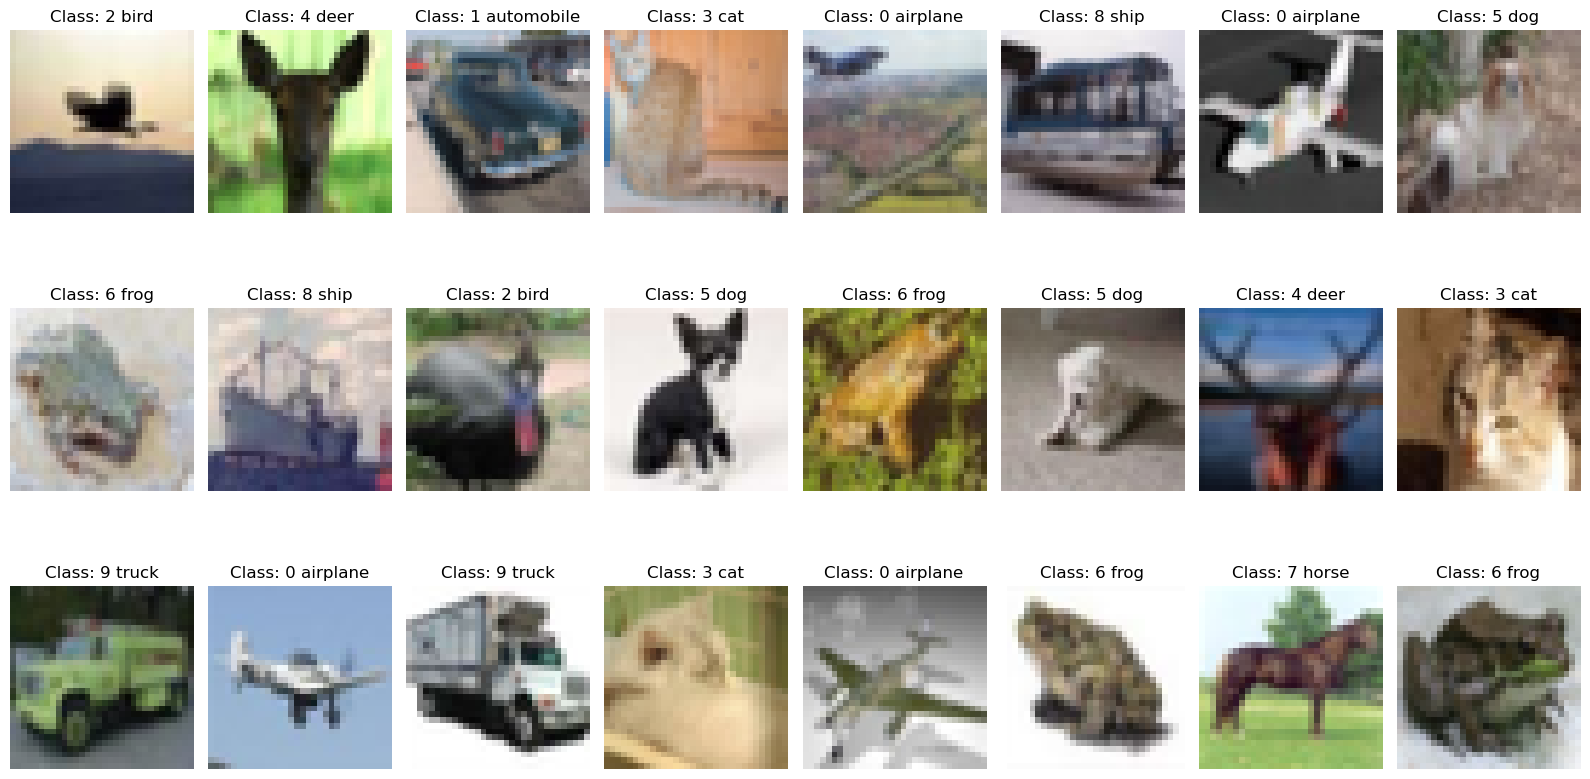

In [6]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
utils.plot_data(exp,3,8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


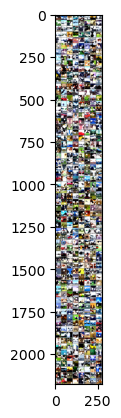

In [7]:
dataiter = iter(transform.train_loader)

images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))


In [8]:
from custom_resnet import Net
model = Net().to(device)

!pip install torchscan --no-deps
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

Defaulting to user installation because normal site-packages is not writeable


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.42E-01


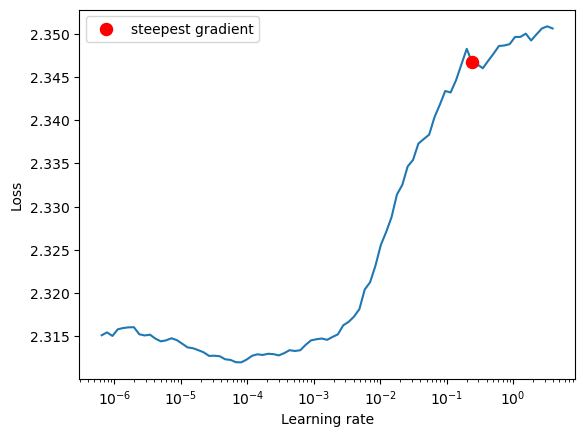

In [9]:
lrmax=0.001
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lrmax)

utils.find_lr(model, optimizer, criterion, transform.train_loader)

In [12]:
#Train again with one cycle policy now
EPOCHS = 24
max_epoch=5

scheduler = OneCycleLR(optimizer=optimizer, max_lr=lrmax, epochs=EPOCHS, steps_per_epoch=len(transform.train_loader), pct_start=max_epoch/EPOCHS, verbose = True, div_factor=10, three_phase = False, base_momentum = 0.8)

In [13]:
net, history = main.fit_model(model, device, transform.train_loader, transform.test_loader, optimizer, criterion, scheduler, EPOCHS)

EPOCH: 1 (LR: 0.01999999999999999)


Batch_id=6 Loss=2.34258 Accuracy=10.60:   7%|▋         | 7/98 [01:34<20:24, 13.45s/it]


KeyboardInterrupt: 

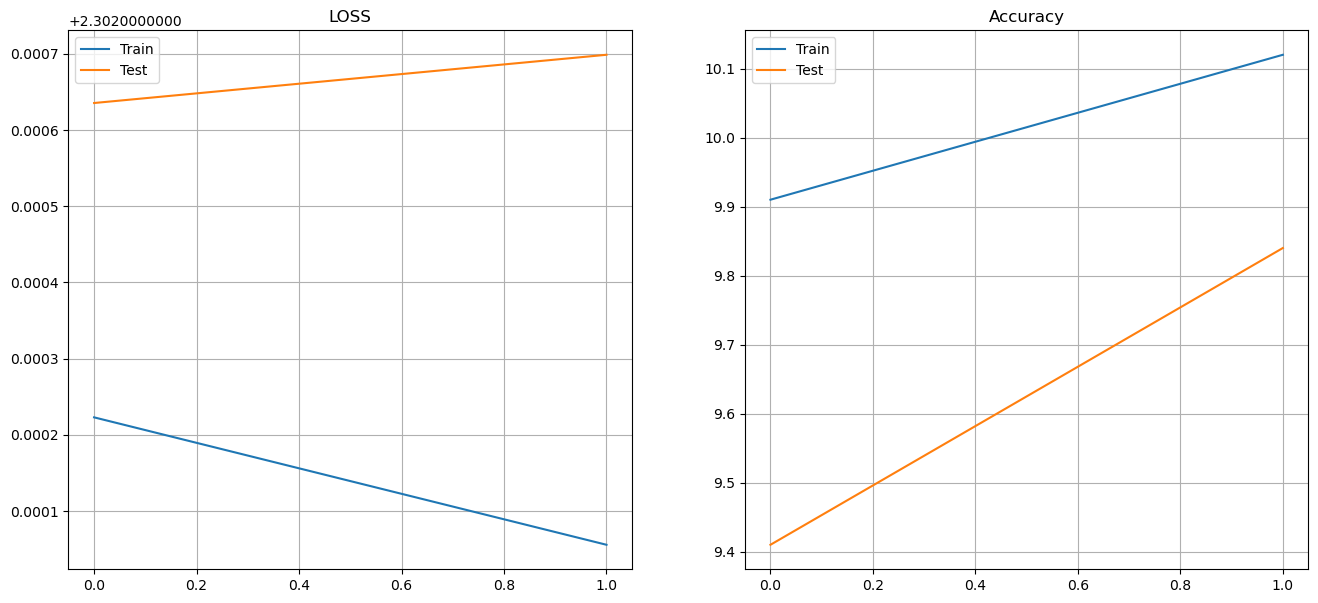

In [ ]:
utils.result_graphs(history)

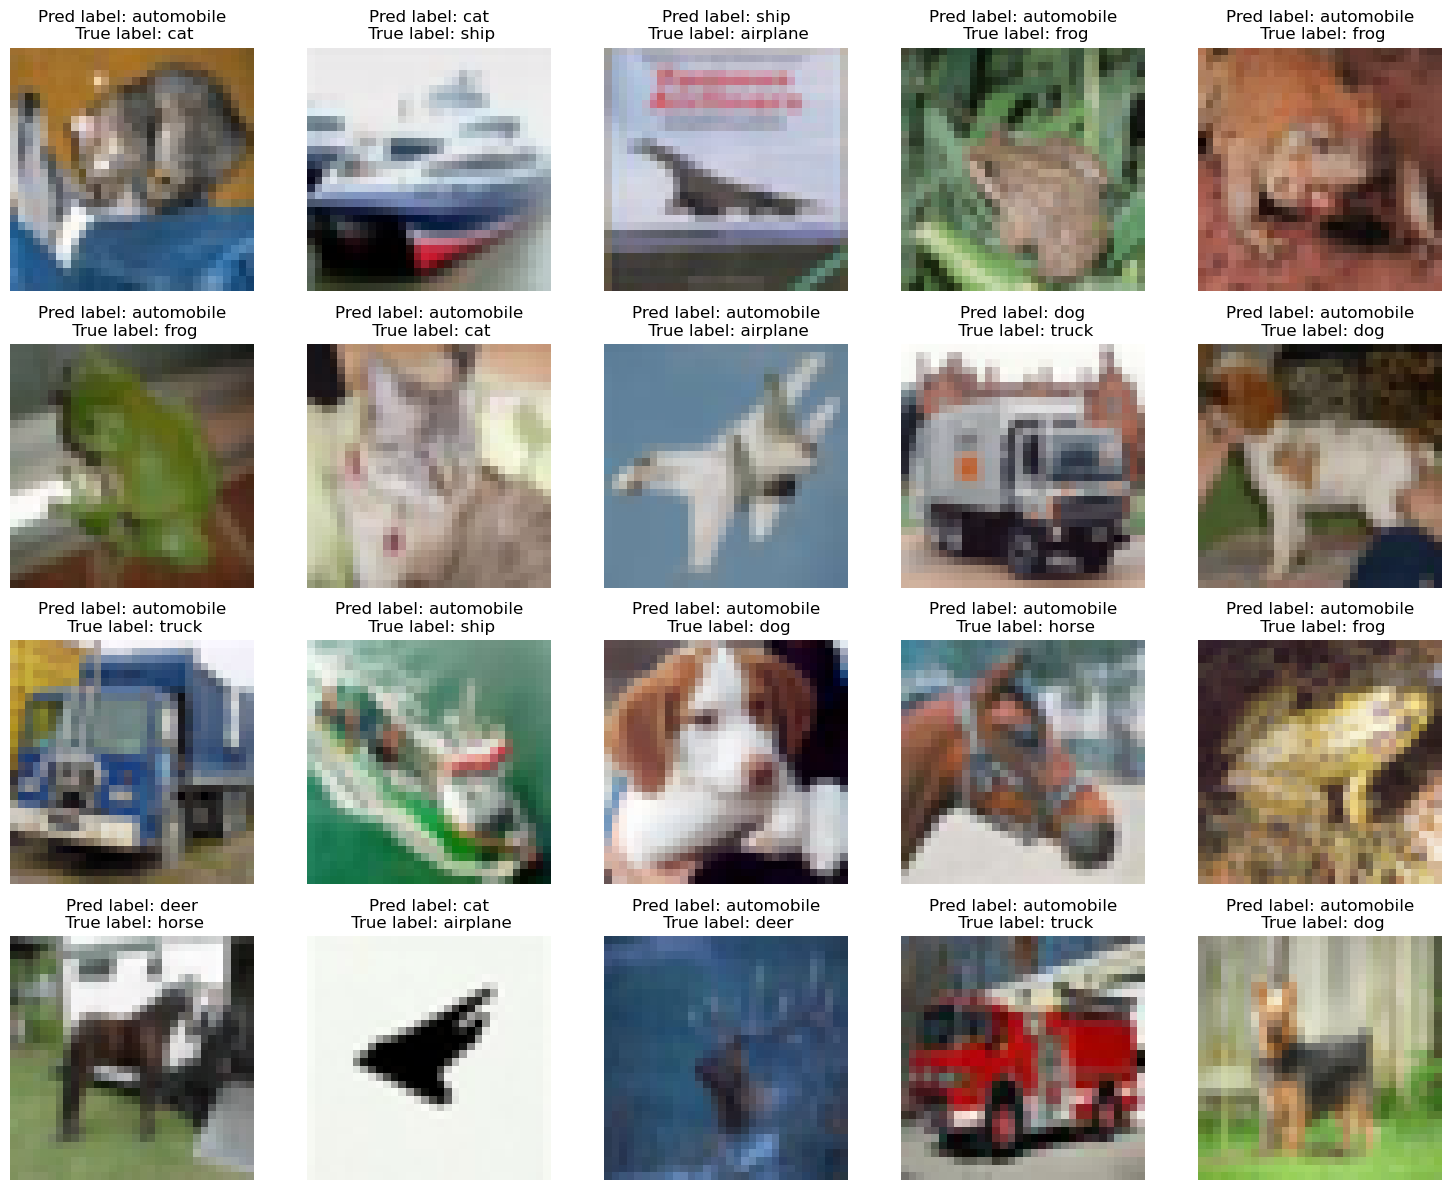

In [ ]:
misclf = utils.plot_misclassified(net, transform.test_loader, transform.testset.classes, device, mean, std, return_misclf=True)